# Task

With AI-modelling and Data Science there is plenty of opportunity to improve processes or suggest improved ways of doing things. When doing so it is often very smart and efficient (time is a scarce resource) to create a POC (Proof of Concept) which basically is a small demo checking wether it is worthwile going further with something. It is also something concrete which facilitates discussions, do not underestimate the power of that. 

In this example, you are working in a company that sells houses and they have a "manual" process of setting prices by humans. You as a Data Scientist can make this process better by using Machine Learning. Your task is to create a POC that you will present to your team colleagues and use as a source of discussion of wether or not you should continue with more detailed modelling. 

Two quotes to facilitate your reflection on the value of creating a PoC: 

"*Premature optimization is the root of all evil*". 

"*Fail fast*".


**More specifially, do the following:**
1. A short EDA (Exploratory Data Analysis) of the housing data set.
2. Drop the column `ocean_proximity`, then you only have numeric columns which will simplify your analysis. Remember, this is a POC! 
3. You have missing values in your data (not sure you do but you can assume so). Handle this with `SimpleImputer(strategy="median")`. (Check the fantastic Scikit-learn documentation for details.) Notice, the `SimpleImputer` should only be used for transformation on the validation and test data, not fitting.
4. Split your data into `X` and `y`, and then into train, validation and test sets. 
5. Create one `LinearRegression` model and one `Lasso` model. For the `Lasso` model, use `GridSearchCV` to optimize $\alpha$ values. Choose yourself which $\alpha$ values to evaluate.
Use RMSE as a metric to decide which model to choose. 

6. Which model is best on the validation data? 

7. Evaluate your chosen model on the test set using the root mean squared error (RMSE) as the metric. 
What are your conclusions? Note: to be 100% sure, you should re-fit your chosen model on the combination of train+val data. 

8. Do a short presentation (~ 2-5 min) on your POC that you present to your colleagues (no need to prepare anything particular, just talk from the code). Think of:
- What do you want to highlight/present?
- What is your conclusion?
- What could be the next step? Is the POC convincing enough or is it not worthwile continuing? Do we need to dig deeper into this before taking some decisions?

------------
Bonus question for those who have time and are ambitious: Redo everything above (copy your code) but in step 2, include the column `ocean_proximity` which is a categorical column. 

# Code

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures    

from sklearn.metrics import root_mean_squared_error

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split

In [53]:
# Below, set your own path where you have stored the data file if it is not in the /data folder. 
# Jag valde att ta in 1000 rader

def load_housing_data(housing_path='data/housing.csv', batch_size=1000, start_row=0):
    """
    Laddar en ny batch med data från en CSV-fil.

    Parametrar:
    - housing_path: Sökvägen till CSV-filen
    - batch_size: Antal rader att läsa in
    - start_row: Vilken rad vi ska börja från (för att inte få samma data varje gång)

    Returnerar:
    - DataFrame med den hämtade datan
    """
    df = pd.read_csv(housing_path, skiprows=range(1, start_row+1), nrows=batch_size)  # Skippar tidigare rader
    return df

# Exempel: Hämta de nästa 1000 raderna från rad 1000
df = load_housing_data(start_row=1000)



In [54]:
# Droppar ocean_proximity
df = df.drop(columns=["ocean_proximity"])  

# Definiera features (X) och målvariabel (y)
X = df.drop(columns=["median_house_value"])  
y = df["median_house_value"]


In [55]:
# Delar upp i träningsdata, valideringsdata och testdata

X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)


In [56]:
#Imputera saknade värden (fit på train, transform på val/test)
imputer = SimpleImputer(strategy="median")
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)
X_test_imputed = imputer.transform(X_test)


## EDA

In [57]:
# Grundläggande information om datasetet

print(df.head())
print(df.shape)
print(df.info())
print(df.describe())

# Kontrollera saknade värden
print("Saknade värden per kolumn:")
print(df.isnull().sum())

# Utforska kategoriska kolumner
print("Unika värden per kolumn:")
print(df.nunique())


column_info = []

for col in df.columns:
    dtype = df[col].dtype
    col_type = "categorical" if dtype == 'object' else "int/float"
    column_info.append([col, col_type])

column_summary = pd.DataFrame(column_info, columns=["Name", "Type"])
print(column_summary)

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -121.76     37.69                29.0       3433.0           711.0   
1    -121.77     37.68                36.0       1687.0           372.0   
2    -121.78     37.69                34.0       2358.0           498.0   
3    -121.78     37.69                35.0       2853.0           588.0   
4    -121.79     37.69                25.0       6296.0          1082.0   

   population  households  median_income  median_house_value  
0      1919.0       709.0         3.3841            184400.0  
1       950.0       372.0         3.5532            158400.0  
2      1157.0       461.0         3.3618            174600.0  
3      1761.0       572.0         4.3533            168400.0  
4      3200.0      1047.0         4.5357            188400.0  
(1000, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  --

In [58]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,1000.000000,1000.000000,1000.000000,1000.000000,995.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,-121.724540,38.393660,25.129000,2809.143000,521.023116,1267.690000,474.857000,3.927841,174388.216000
std,0.739948,0.798253,12.028676,2139.169036,374.448255,933.963189,354.275005,2.004479,100238.412396
min,-124.300000,36.720000,2.000000,44.000000,6.000000,23.000000,9.000000,0.536000,22500.000000
25%,-122.110000,37.930000,16.000000,1523.250000,293.500000,715.750000,266.000000,2.501500,102200.000000
50%,-121.940000,37.995000,24.000000,2263.500000,427.000000,1049.500000,389.500000,3.500000,145400.000000
75%,-121.580000,38.775000,34.000000,3370.000000,624.500000,1558.250000,572.000000,4.984125,212500.000000
max,-119.770000,41.950000,52.000000,20354.000000,3493.000000,8768.000000,3293.000000,15.000100,500001.000000


<Axes: >

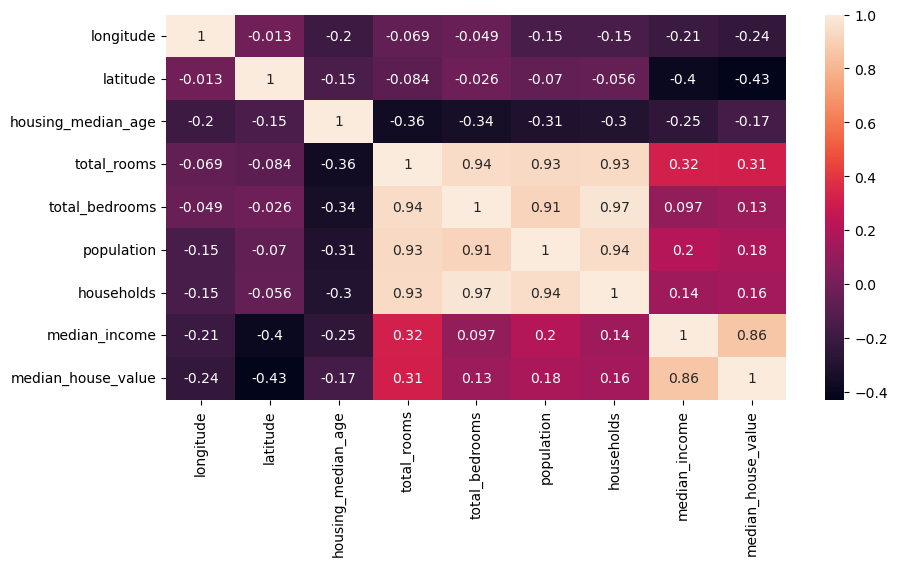

In [59]:
#Korrelationsmatris
correlation_matrix = df.corr()
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(correlation_matrix, annot=True, ax=ax)

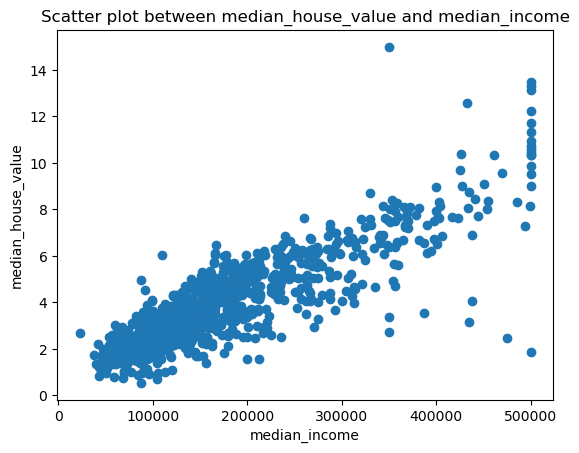

In [60]:
# Scatter plot between the target (median_house_value) and median_income.
plt.scatter(df["median_house_value"], df["median_income"])
plt.title("Scatter plot between median_house_value and median_income")
plt.xlabel("median_income") 
plt.ylabel("median_house_value")
plt.show()

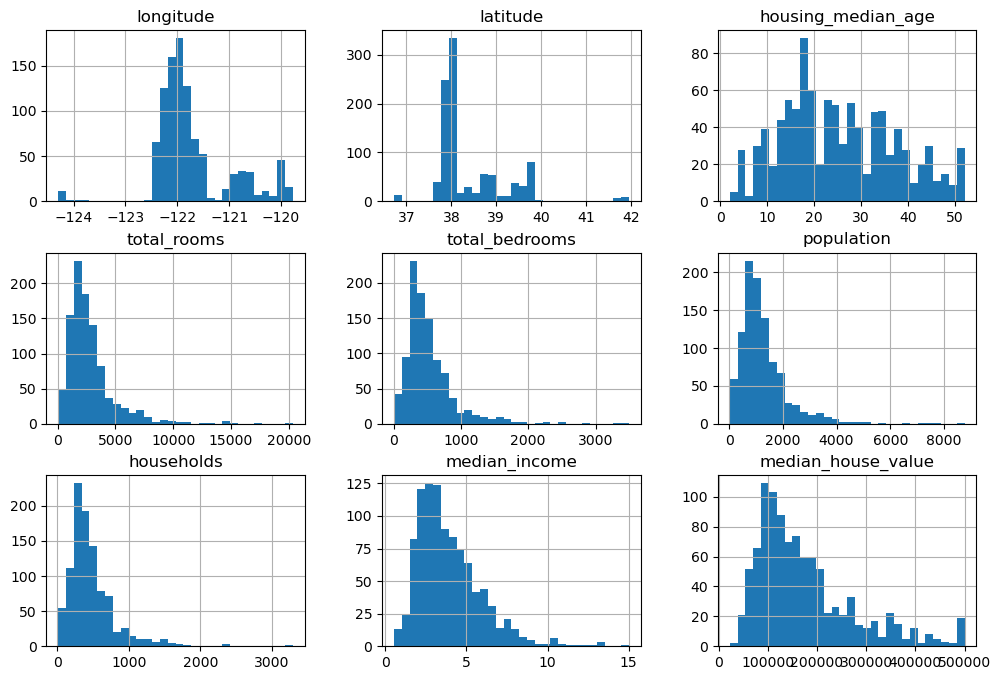

In [61]:
# Visualisera fördelningen av numeriska kolumner
import matplotlib.pyplot as plt

df.hist(figsize=(12,8), bins=30)
plt.show()

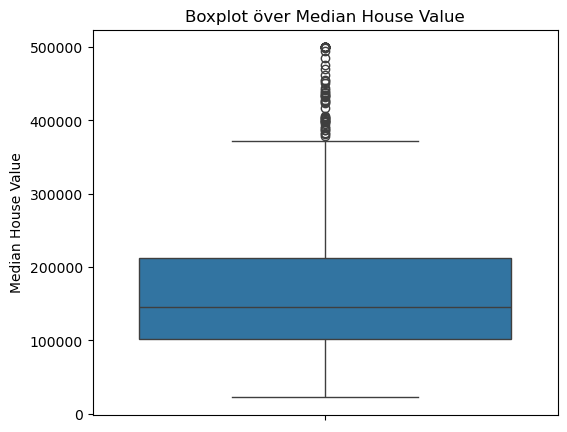

In [62]:
plt.figure(figsize=(6, 5))
sns.boxplot(y=df['median_house_value'])
plt.ylabel('Median House Value')
plt.title('Boxplot över Median House Value')
plt.show()


In [63]:
#Skala data (fit på train, transform på val/test)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

#Konvertera tillbaka till DataFrame för att kunna använda kolumnnamn
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

## Preparing data

In [64]:
# Utvärdera outliers

column = 'median_house_value'

# Beräkna kvartiler och interkvartilavstånd (IQR)
Q1 = df[column].quantile(0.25)  # Första kvartilen
Q3 = df[column].quantile(0.75)  # Tredje kvartilen
IQR = Q3 - Q1  # Interkvartilavstånd

# Definiera outlier-gränser enligt Tukey's rule (1.5 * IQR)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Räkna antalet outliers
outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
num_outliers = outliers.shape[0]

# Beräkna medelvärdet för hela datasetet och utan outliers
mean_with_outliers = df[column].mean()
mean_without_outliers = df[~df[column].isin(outliers[column])][column].mean()

#Andel outliers
total_rows = df.shape[0]
outlier_percentage = (num_outliers / total_rows) * 100

# Visa resultaten
num_outliers, mean_with_outliers, mean_without_outliers, outlier_percentage


(56, 174388.216, 158288.98305084746, 5.6000000000000005)

Då outliers endats utgör 3% av antalet värden och och liten utsträckning (3,8%) påverkar medelvärdet väljer jag att ha kvar outliers. 

## Models

In [65]:
#Lasso

# Testar olika alpha-värden för Lasso

alphas = [0.1, 10, 100, 500, 1000]
best_alpha = None
best_rmse = float("inf")
feature_removal = {}

for alpha in alphas:
    print(f"\n🔹 Lasso Regression med alpha={alpha}")

    lasso_reg = Lasso(alpha=alpha, max_iter=5000)

    scores_rmse = cross_val_score(lasso_reg, X_train_imputed, y_train, cv=3, scoring='neg_root_mean_squared_error')

    mean_rmse = np.mean(-scores_rmse)

    print("RMSE för varje iteration:", -scores_rmse)
    print("Medelvärde RMSE:", mean_rmse)

    lasso_reg.fit(X_train_imputed, y_train)
    num_zero_coefs = np.sum(lasso_reg.coef_ == 0)

    print(f"Antal features satta till 0 av Lasso: {num_zero_coefs}")
    feature_removal[alpha] = num_zero_coefs  # Spara antal borttagna features

    if mean_rmse < best_rmse:
        best_rmse = mean_rmse
        best_alpha = alpha

# Säkerställ att vi hittade ett giltigt alpha
if best_alpha is None:
    print("\n❌ Inget fungerande alpha-värde hittades! Avbryter.")
    exit()

print(f"\n Bästa alpha-värde: {best_alpha} med RMSE: {best_rmse:.2f}")



🔹 Lasso Regression med alpha=0.1
RMSE för varje iteration: [48988.75485852 36808.42297197 50714.16748192]
Medelvärde RMSE: 45503.78177080277
Antal features satta till 0 av Lasso: 0

🔹 Lasso Regression med alpha=10
RMSE för varje iteration: [48989.55966248 36806.44039693 50714.71448086]
Medelvärde RMSE: 45503.5715134241
Antal features satta till 0 av Lasso: 0

🔹 Lasso Regression med alpha=100
RMSE för varje iteration: [48997.7204301  36789.04024368 50720.11699891]
Medelvärde RMSE: 45502.29255756154
Antal features satta till 0 av Lasso: 1

🔹 Lasso Regression med alpha=500
RMSE för varje iteration: [49043.705147   36726.78633813 50753.49818093]
Medelvärde RMSE: 45507.99655535541
Antal features satta till 0 av Lasso: 0

🔹 Lasso Regression med alpha=1000
RMSE för varje iteration: [49123.81682247 36679.68201733 50816.70003924]
Medelvärde RMSE: 45540.06629301311
Antal features satta till 0 av Lasso: 0

 Bästa alpha-värde: 100 med RMSE: 45502.29


In [66]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Skapar Lasso med bästa alpha-värde och linjär regression
lasso_reg = Lasso(alpha=100, max_iter=5000)  
lin_reg = LinearRegression()

# Träna modellerna på träningsdatan
lasso_reg.fit(X_train_imputed, y_train)
lin_reg.fit(X_train_imputed, y_train)

# Gör prediktioner på träningsdatan
y_train_pred_lasso = lasso_reg.predict(X_train_imputed)
y_train_pred_lin = lin_reg.predict(X_train_imputed)

# Gör prediktioner på valideringsdatan
y_pred_lasso = lasso_reg.predict(X_val_imputed)
y_pred_lin = lin_reg.predict(X_val_imputed)

# Beräkna RMSE för tränings- och valideringsdata
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_train_lasso = root_mean_squared_error(y_train, y_train_pred_lasso)
rmse_train_lin = root_mean_squared_error(y_train, y_train_pred_lin)

rmse_val_lasso = root_mean_squared_error(y_val, y_pred_lasso)
rmse_val_lin = root_mean_squared_error(y_val, y_pred_lin)

# Skriver ut resultaten
print("\n Utvärdering på träningsdatan:")
print(f"RMSE för Lasso (alpha=100) - Träning: {rmse_train_lasso}")
print(f"RMSE för Linjär Regression - Träning: {rmse_train_lin}")

print("\n Utvärdering på valideringsdatan:")
print(f"RMSE för Lasso (alpha=100) - Validering: {rmse_val_lasso}")
print(f"RMSE för Linjär Regression - Validering: {rmse_val_lin}")

# Välj bästa modellen baserat på validerings-RMSE
best_model = None
if rmse_val_lasso < rmse_val_lin:
    print("\n Lasso valdes som den bästa modellen baserat på validerings-RMSE.")
    best_model = lasso_reg
else:
    print("\n Linjär Regression valdes som den bästa modellen baserat på validerings-RMSE.")
    best_model = lin_reg




 Utvärdering på träningsdatan:
RMSE för Lasso (alpha=100) - Träning: 45190.84085468428
RMSE för Linjär Regression - Träning: 45190.283903619245

 Utvärdering på valideringsdatan:
RMSE för Lasso (alpha=100) - Validering: 65778.78741887076
RMSE för Linjär Regression - Validering: 65762.16898552561

 Linjär Regression valdes som den bästa modellen baserat på validerings-RMSE.


In [67]:
# Utvärdering på TESTDATA efter att valt Lasso
from sklearn.metrics import root_mean_squared_error

y_pred_test = best_model.predict(X_test_imputed)
rmse_test = root_mean_squared_error(y_test, y_pred_test)

print(f"\n RMSE på testdatan med vald modell: {rmse_test}")



 RMSE på testdatan med vald modell: 50006.19105820018


In [68]:
# Beräkna medelvärdet av y_test
mean_y_test = np.mean(y_test)

print(f"\n Medelvärde av y_test: {mean_y_test:.2f}")
print(f" RMSE på testdatan: {rmse_test:.2f}")
print(f" Fel i procent av medelvärdet: {rmse_test / mean_y_test * 100:.2f}%")



 Medelvärde av y_test: 176210.03
 RMSE på testdatan: 50006.19
 Fel i procent av medelvärdet: 28.38%


## Evaluation

Linjär regression och Lasso prestererar nästan identiskt på både tränings och valideringsdatan. Jag testade att droppa olika features men fick de presterade fortsatt samma. Lasson stryper inte heller själv några features och fungerar som en linjär regression.

Conclusions

Vi behöver testa med fler modeller, tex en icke-linjär modell som Radom Forest för att se om en mer flexibel modell presterar bättre. 

In [ ]:
#Skala data (fit på train, transform på val/test)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

#Konvertera tillbaka till DataFrame för att kunna använda kolumnnamn
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)